Варьируя параметры ансамбля в подходам блэндинг и стэкинг, обучить оптимальный классификатор.Визуализировать графики зависимости предсказания от параметров модели.

c:\Users\Kristofer\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


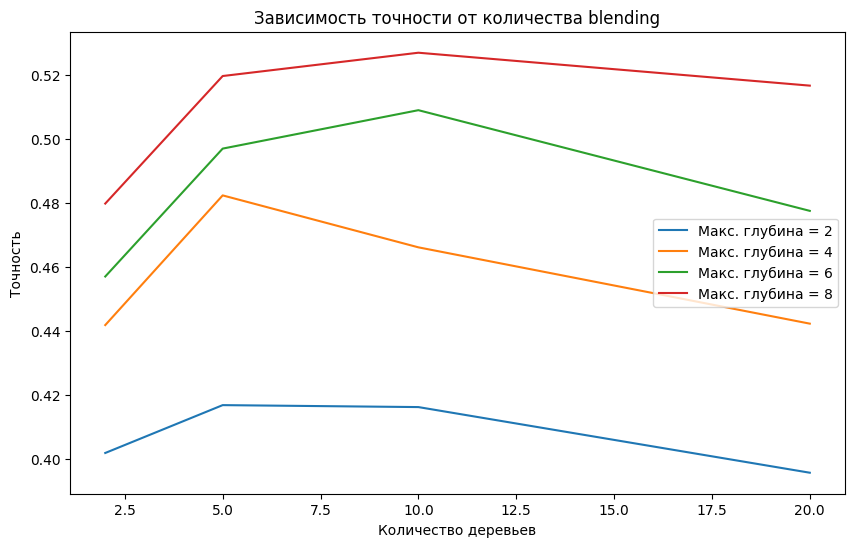

In [1]:
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from nltk.corpus import stopwords

dataset = load_dataset('json', data_files={'train': 'train.jsonl','test':'validation.jsonl'})

# Преобразование текста в векторное представление
vectorizer = CountVectorizer(max_features=500, min_df=4, max_df=0.7, stop_words=stopwords.words('english'))
X_train_vec = vectorizer.fit_transform(dataset['train']['text'])
tfidf = TfidfTransformer()
X_train_idf = tfidf.fit_transform(X_train_vec)
X_test_vec = vectorizer.transform(dataset['test']['text'])
X_test_idf = tfidf.transform(X_test_vec)
X_train = X_train_idf.toarray()
X_test = X_test_idf.toarray()
y_train, y_test = dataset['train']['label'], dataset['test']['label']

# Разделение на тренировочную и тестовую выборки
X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

def get_params():
    return [2, 5, 10, 20], [2, 4, 6, 8], [5, 10, 20], [4, 6, 8]

# Визуализация результатов
def visual(results, method):
    n_estimators_list, max_depth_list, _, _ = get_params()

    plt.figure(figsize=(10, 6))

    for max_depth in max_depth_list:
        subset = [
            np.mean([r['accuracy'] for r in results
                    if r['base_max_depth'] == max_depth and r['base_n_estimators'] == n])
            for n in n_estimators_list
        ]
        plt.plot(n_estimators_list, subset, label=f'Макс. глубина = {max_depth}')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Точность')
    plt.title(f'Зависимость точности от количества {method}')
    plt.legend()
    plt.show()

    # Блэндинг
def make_blending_prediction(basic_clfs, final_clf, data):
    y0 = [clf.predict(data) for clf in basic_clfs]
    y0_t = np.array(y0).transpose()
    return final_clf.predict(y0_t)

def get_results_blending():
    n_estimators_list, max_depth_list, final_n_estimators, final_max_depth = get_params()
    results = []

    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            crf = []
            y_pred_1 = []
            for n in range(1, 11):  # Количество базовых классификаторов в ансамбле
                clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=n)
                clf.fit(X_train_0, y_train_0)
                crf.append(clf)
                y_pred_1.append(clf.predict(X_train_1).reshape(-1, 1))
            y_pred_1t = np.array(y_pred_1).transpose()[0]

            # Перебор параметров финального классификатора
            for fn in final_n_estimators:
                for fd in final_max_depth:
                    clf_final = RandomForestClassifier(n_estimators=fn, max_depth=fd, random_state=42)
                    clf_final.fit(y_pred_1t, y_train_1)

                    # Оценка на тестовых данных
                    y_test_pred = make_blending_prediction(crf, clf_final, X_test)
                    acc = metrics.accuracy_score(y_test, y_test_pred)

                    # Сохраняем результаты
                    results.append({
                        'base_n_estimators': n_estimators,
                        'base_max_depth': max_depth,
                        'final_n_estimators': fn,
                        'final_max_depth': fd,
                        'accuracy': acc
                    })
    return results

visual(get_results_blending(), 'blending')

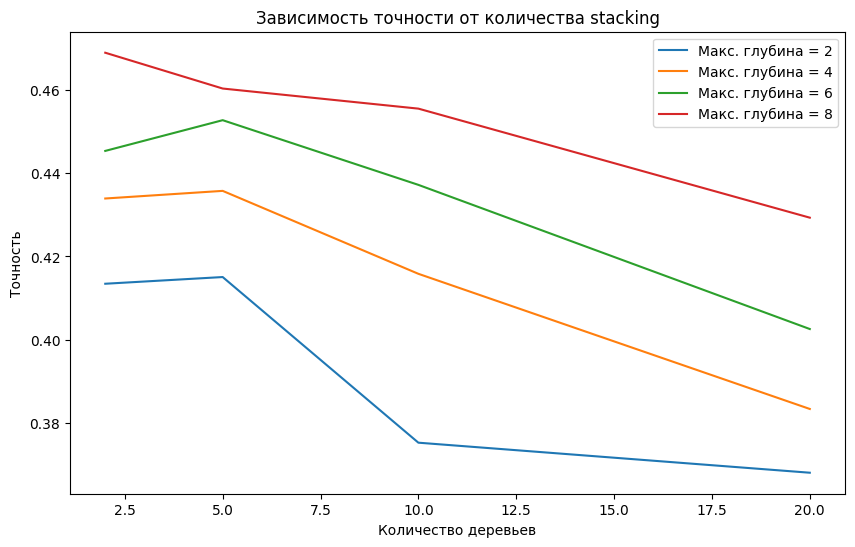

In [2]:
# Стекинг
def make_stacking_prediction(basic_clfs, final_clf, data):
    y0 = [clf.predict(data) for clf in basic_clfs]
    y0_t = np.array(y0).transpose()
    return final_clf.predict(y0_t)

def get_results_stacking():
    n_estimators_list, max_depth_list, final_n_estimators, final_max_depth = get_params()
    results = []

    kf = KFold(n_splits=10, random_state=None, shuffle=True)

    # Перебор параметров базовых классификаторов
    for base_n_estimators in n_estimators_list:
        for base_max_depth in max_depth_list:
            pre_prediction = np.zeros((len(X_train), kf.get_n_splits()))
            crf_stack = []

            # KFold для стекинга
            for i, (train_index, test_index) in enumerate(kf.split(X_train)):
                X_train_0, X_test_1 = np.array(X_train)[train_index], np.array(X_train)[test_index]
                y_train_0, y_test_1 = np.array(y_train)[train_index], np.array(y_train)[test_index]

                # Базовые классификаторы
                clf = RandomForestClassifier(n_estimators=base_n_estimators, max_depth=base_max_depth, random_state=i)
                clf.fit(X_train_0, y_train_0)
                crf_stack.append(clf)
                pre_prediction[test_index, i] = clf.predict(X_test_1)

            # Перебор параметров финального классификатора
            for final_n in final_n_estimators:
                for fd in final_max_depth:
                    clf_stack_final = RandomForestClassifier(n_estimators=final_n, max_depth=fd, random_state=42)
                    clf_stack_final.fit(pre_prediction, y_train)

                    # Оценка на тестовых данных
                    y_test_pred = make_stacking_prediction(crf_stack, clf_stack_final, X_test)
                    acc = metrics.accuracy_score(y_test, y_test_pred)

                    # Сохраняем результаты
                    results.append({
                        'base_n_estimators': base_n_estimators,
                        'base_max_depth': base_max_depth,
                        'final_n_estimators': final_n,
                        'final_max_depth': fd,
                        'accuracy': acc
                    })

    return results
visual(get_results_stacking(), 'stacking')